## Requirments 

In [5]:
from Util import GREEN_TAXI

import pandas as pd
import numpy as np

from datetime import *
import time

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import scipy
import statsmodels.api as sm

import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
#from arch import arch_model

import warnings

import os
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set()

import plotly.express as px
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["figure.figsize"]=(20,12)
mpl.rcParams['axes.grid']=True
pd.options.display.float_format = '{:.7f}'.format

#import geopy


In [6]:
def return_calculator(x:str,y:float):
    return (y-DICT_Daily_base[x])/DICT_Daily_base[x]
    
def revise_return_calculator(x:str,y:float):
    return y*DICT_Daily_base[x]+DICT_Daily_base[x]


## Load data

In [7]:
df=GREEN_TAXI.pd.read_csv("./data/updated_RAW_TAXI.csv")

In [8]:
df=df.groupby(['P_Day','P_WEEK_Day', 'P_Hour'])["flag"].sum().reset_index()

In [9]:
df

,P_Day,P_WEEK_Day,P_Hour,flag
0,1,Monday,0,1285
1,1,Monday,1,813
2,1,Monday,2,576
3,1,Monday,3,424
4,1,Monday,4,460
...,...,...,...,...
691,29,Monday,19,2812
692,29,Monday,20,2519
693,29,Monday,21,2175
694,29,Monday,22,1764


## Feature Generation:

In [10]:
Week_day_Hourly=df.groupby(["P_WEEK_Day","P_Hour"])['flag'].mean().reset_index()


In [11]:


df["ID"]=df.apply(lambda x: GREEN_TAXI.ConcatX([x.P_WEEK_Day,x.P_Hour]),axis=1)
Week_day_Hourly["ID"]=Week_day_Hourly.apply(lambda x: GREEN_TAXI.ConcatX([x.P_WEEK_Day,x.P_Hour]),axis=1)

DICT_Daily_base=dict(zip(Week_day_Hourly["ID"],Week_day_Hourly["flag"]))

#### Diffrence with the average same day (point to point Monday to Avg Monday , ...)
df["Return"]=df.apply(lambda x: return_calculator(x.ID,x.flag),axis=1)
#### return ( hourly difrenece)
df['Daily_Return'] = df.flag.pct_change(1)


days = GREEN_TAXI.pd.get_dummies(df.P_WEEK_Day)
df=GREEN_TAXI.pd.concat([df, days], axis=1)


Features=["flag","Return","Daily_Return","P_Hour","Friday","Monday","Saturday","Sunday","Thursday","Tuesday","Wednesday"]
tarrget="flag"


df=df.fillna(method="ffill")
df=df.fillna(method="bfill")

df["ID"]=df.apply(lambda x: GREEN_TAXI.ConcatX(["2016_2",int(x.P_Day),int(x.P_Hour)]),axis=1)
df=df.set_index("ID")

df=df[Features]


df.head(20)


,flag,Return,Daily_Return,P_Hour,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
ID,,,,,,,,,,,
2016_2_1_0,1285,-0.2426921,-0.3673152,0,0,1,0,0,0,0,0
2016_2_1_1,813,-0.2370495,-0.3673152,1,0,1,0,0,0,0,0
2016_2_1_2,576,-0.1903289,-0.2915129,2,0,1,0,0,0,0,0
2016_2_1_3,424,-0.1734893,-0.2638889,3,0,1,0,0,0,0,0
2016_2_1_4,460,-0.1528545,0.0849057,4,0,1,0,0,0,0,0
2016_2_1_5,457,-0.0201544,-0.0065217,5,0,1,0,0,0,0,0
2016_2_1_6,775,-0.0297947,0.6958425,6,0,1,0,0,0,0,0
2016_2_1_7,1880,0.1359517,1.4258065,7,0,1,0,0,0,0,0
2016_2_1_8,2636,0.1077492,0.4021277,8,0,1,0,0,0,0,0


### Data Scaler:

In [12]:
Fscaler=MinMaxScaler()
data_scaled=Fscaler.fit_transform(df[Features])

Tscaler=MinMaxScaler()
TargeT=Tscaler.fit_transform(df[tarrget][:,np.newaxis])

df_S=pd.DataFrame(columns=df.columns,data=data_scaled,index=df.index) # Scaled dataset 


In [13]:
TargeT[:5]


array([[0.21110194],
       [0.11370202],
       [0.06479571],
       [0.03342963],
       [0.04085844]])

In [14]:
## Scaled Dataset view 
df_S

,flag,Return,Daily_Return,P_Hour,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
ID,,,,,,,,,,,
2016_2_1_0,0.2111019,0.1406735,0.0830966,0.0000000,0.0000000,1.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2016_2_1_1,0.1137020,0.1453273,0.0830966,0.0434783,0.0000000,1.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2016_2_1_2,0.0647957,0.1838605,0.1159116,0.0869565,0.0000000,1.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2016_2_1_3,0.0334296,0.1977492,0.1278701,0.1304348,0.0000000,1.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2016_2_1_4,0.0408584,0.2147679,0.2788642,0.1739130,0.0000000,1.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
...,...,...,...,...,...,...,...,...,...,...,...
2016_2_29_19,0.5262072,0.3593692,0.2258115,0.8260870,0.0000000,1.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2016_2_29_20,0.4657449,0.3809375,0.1970015,0.8695652,0.0000000,1.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2016_2_29_21,0.3947586,0.3863714,0.1829902,0.9130435,0.0000000,1.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


In [15]:
START='2016_2_12_10'
END='2016_2_12_22'

test=df_S[START:END]
#Test_target=df_S["flag"][START:END].values
Test_target=df_S["flag"][START:END][:,np.newaxis]
Test_target[:5]

array([[0.42075939],
       [0.39290136],
       [0.361948  ],
       [0.37866281],
       [0.50495254]])

# Regresion Meodle

#### 1) Auto Arima Single Variable 

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  696
Model:             SARIMAX(2, 0, 3)x(1, 0, 3, 10)   Log Likelihood                1045.673
Date:                            Mon, 21 Jun 2021   AIC                          -2069.345
Time:                                    03:14:01   BIC                          -2019.346
Sample:                                         0   HQIC                         -2050.013
                                            - 696                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0106      0.003      3.076      0.002       0.004       0.017
ar.L1          1.8116      0.028   

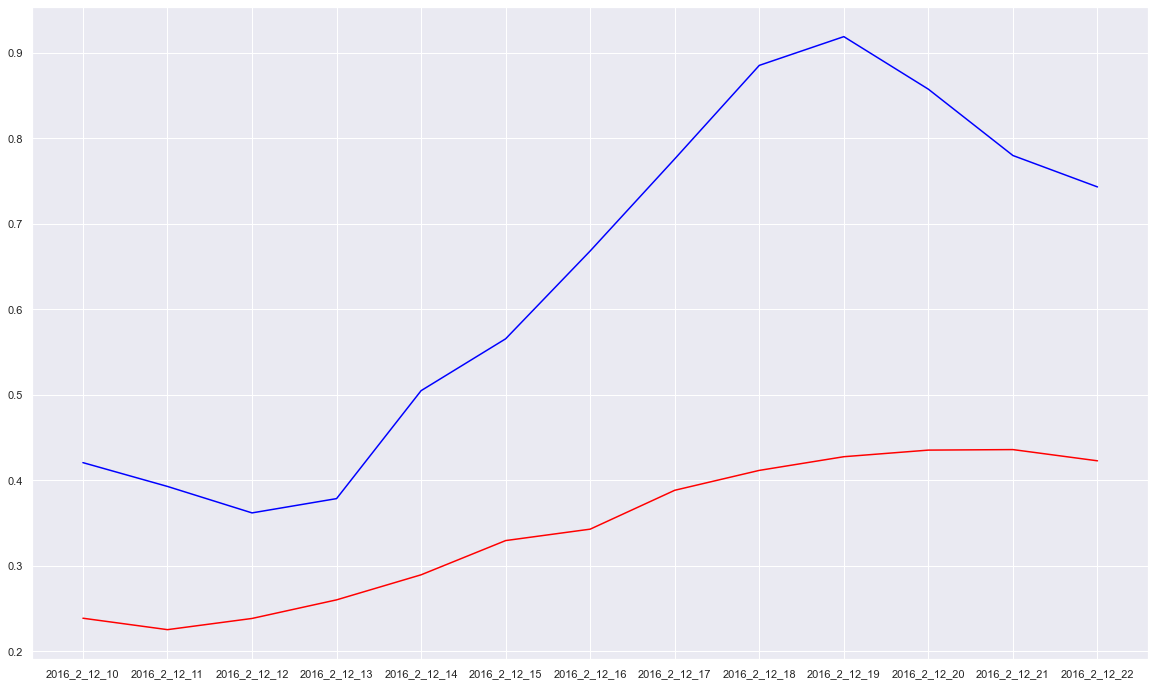

In [16]:
model_auto = auto_arima(TargeT,error_action='ignore',  
       suppress_warnings=True, stepwise=True,
        m = 10, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)
print(model_auto.summary())

model_auto.fit(TargeT)

forecast = model_auto.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

#plot the predictions for validation set
#plt.plot(train.flag, label='Train')
plt.plot(test.flag, label='Valid',color = "blue")
plt.plot(forecast, label='Prediction',color = "red")
plt.show()

#### 2) SARIMAX ( multi Variable )

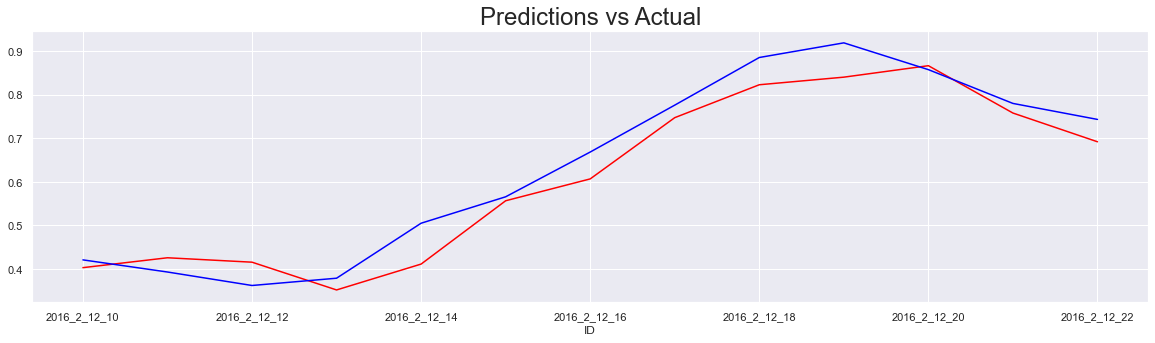

In [17]:
model_ret_sarimax = SARIMAX(TargeT, exog = df_S[['Friday','Monday','Saturday','Sunday','Thursday','Tuesday','Wednesday']], 
                            order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarimax = model_ret_sarimax.fit()
print(model_ret_sarimax)



#START:END
df_pred_sarimax = results_ret_sarimax.predict(start = START, end = END, 
                                              exog = test[['Friday','Monday','Saturday','Sunday','Thursday','Tuesday','Wednesday']][START:END]) 

df_pred_sarimax[START:END].plot(figsize = (20,5), color = "red")
test.flag[START:END].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

#### 3) AUTO ARIMA Multi Variable

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  696
Model:             SARIMAX(3, 0, 3)x(0, 0, 3, 5)   Log Likelihood                1045.248
Date:                           Mon, 21 Jun 2021   AIC                          -2056.497
Time:                                   03:32:05   BIC                          -1979.226
Sample:                                        0   HQIC                         -2026.619
                                           - 696                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Friday         0.4248      0.015     28.511      0.000       0.396       0.454
Monday         0.3535      0.017     21.091

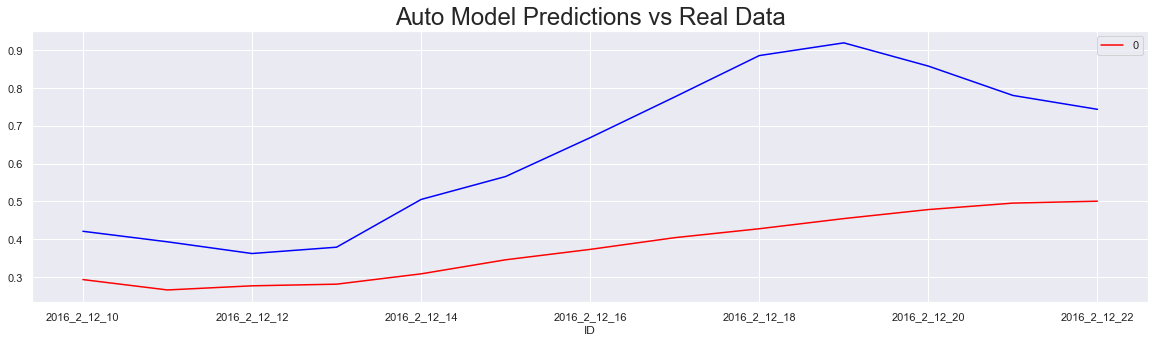

In [18]:
Multi_ARIMA = auto_arima(TargeT, exogenous = df_S[['Friday','Monday','Saturday','Sunday','Thursday','Tuesday','Wednesday']], 
                       m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

print(Multi_ARIMA.summary())

df_auto_pred = pd.DataFrame(Multi_ARIMA.predict(n_periods = len(df_S[START:END]), 
                                              exogenous = test[['Friday','Monday','Saturday','Sunday','Thursday','Tuesday','Wednesday']][START:END])
                           )
                            #index = test.index)
df_auto_pred.plot(figsize = (20,5), color = "red")
test.flag.plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()


# Tensorflow LSTM 

### feature generation :


In [19]:
selected_features=['flag','P_Hour','Friday','Monday','Saturday','Sunday','Thursday','Tuesday','Wednesday']

x_train,x_test,y_train,y_test=train_test_split( df_S[selected_features],TargeT,test_size=0.10, random_state=123,shuffle=False)

#### select for exaple 5 days data to predict next 10 minuts:  5 *24*6 =720
win_lengh= 5 # window size
batch_size=40 # eachtime 40 window as the same time == 40 *5 line at each time 
num_features=len(selected_features) # our features

train_generator=TimeseriesGenerator(x_train,y_train,length=win_lengh,sampling_rate=1,batch_size=batch_size)
test_generator=TimeseriesGenerator(x_test,y_test,length=win_lengh,sampling_rate=1,batch_size=batch_size)

### Callback function for early stop 

In [20]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        #if(logs.get('val_mean_absolute_error')<=0.001):
        if(logs.get('val_loss')<=0.0015):

            print("\nReached 001.% loos validation so cancelling training!")
            self.model.stop_training = True
callbacks = myCallback()

In [21]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128,input_shape=(win_lengh,num_features),return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(128,return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(64,return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))
print(model.summary())

model.compile(loss=tf.losses.MeanSquaredError(),
             optimizer=tf.optimizers.Adam(),
             metrics=[tf.metrics.MeanAbsoluteError()])

history=model.fit_generator(
                            train_generator,
                            epochs=1000,
                            validation_data=test_generator,
                            shuffle=False,
                            callbacks=[callbacks]
                            )


print(model.evaluate_generator(test_generator,verbose=0))
predictions=model.predict_generator(test_generator)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 128)            70656     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 5, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 128)            131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 128)            0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

Epoch 42/1000
16/16 [==============================] - 0s 18ms/step - loss: 0.0047 - mean_absolute_error: 0.0541 - val_loss: 0.0017 - val_mean_absolute_error: 0.0301
Epoch 43/1000
16/16 [==============================] - 0s 18ms/step - loss: 0.0043 - mean_absolute_error: 0.0514 - val_loss: 0.0021 - val_mean_absolute_error: 0.0355
Epoch 44/1000
16/16 [==============================] - 0s 17ms/step - loss: 0.0051 - mean_absolute_error: 0.0555 - val_loss: 0.0027 - val_mean_absolute_error: 0.0368
Epoch 45/1000
16/16 [==============================] - 0s 19ms/step - loss: 0.0041 - mean_absolute_error: 0.0498 - val_loss: 0.0022 - val_mean_absolute_error: 0.0363
Epoch 46/1000
16/16 [==============================] - 0s 18ms/step - loss: 0.0046 - mean_absolute_error: 0.0532 - val_loss: 0.0019 - val_mean_absolute_error: 0.0332
Epoch 47/1000
16/16 [==============================] - 0s 25ms/step - loss: 0.0040 - mean_absolute_error: 0.0484 - val_loss: 0.0025 - val_mean_absolute_error: 0.0366
Epoc

65 70
70 70


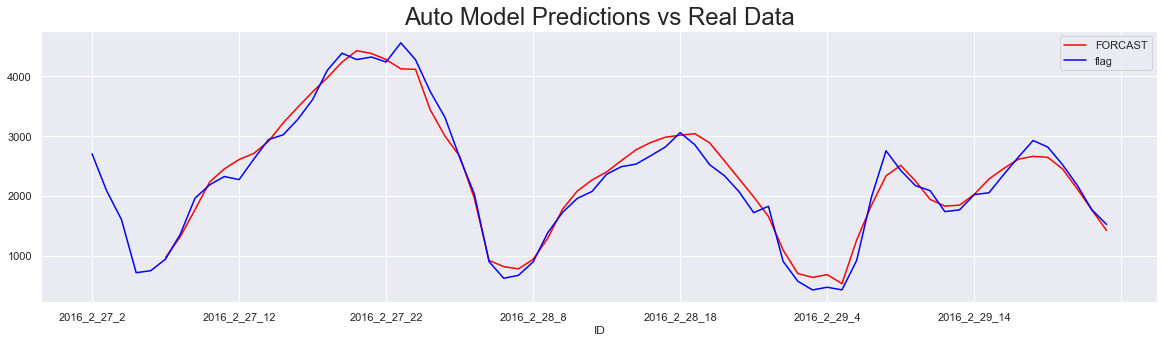

In [22]:
PRED=Tscaler.inverse_transform(predictions)
PRED=[item for sublist in PRED.tolist() for item in sublist]
print(len(PRED),len(y_test))
PRED=[np.nan for x in range(5)]+PRED
print(len(PRED),len(y_test))

report=df_S[-70:]
report["FORCAST"]=PRED

report.FORCAST.plot(figsize = (20,5), color = "red")
df.flag[-70:].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.legend()
plt.show()

In [23]:
df_S

,flag,Return,Daily_Return,P_Hour,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
ID,,,,,,,,,,,
2016_2_1_0,0.2111019,0.1406735,0.0830966,0.0000000,0.0000000,1.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2016_2_1_1,0.1137020,0.1453273,0.0830966,0.0434783,0.0000000,1.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2016_2_1_2,0.0647957,0.1838605,0.1159116,0.0869565,0.0000000,1.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2016_2_1_3,0.0334296,0.1977492,0.1278701,0.1304348,0.0000000,1.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2016_2_1_4,0.0408584,0.2147679,0.2788642,0.1739130,0.0000000,1.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
...,...,...,...,...,...,...,...,...,...,...,...
2016_2_29_19,0.5262072,0.3593692,0.2258115,0.8260870,0.0000000,1.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2016_2_29_20,0.4657449,0.3809375,0.1970015,0.8695652,0.0000000,1.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
2016_2_29_21,0.3947586,0.3863714,0.1829902,0.9130435,0.0000000,1.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


13 70
18 70


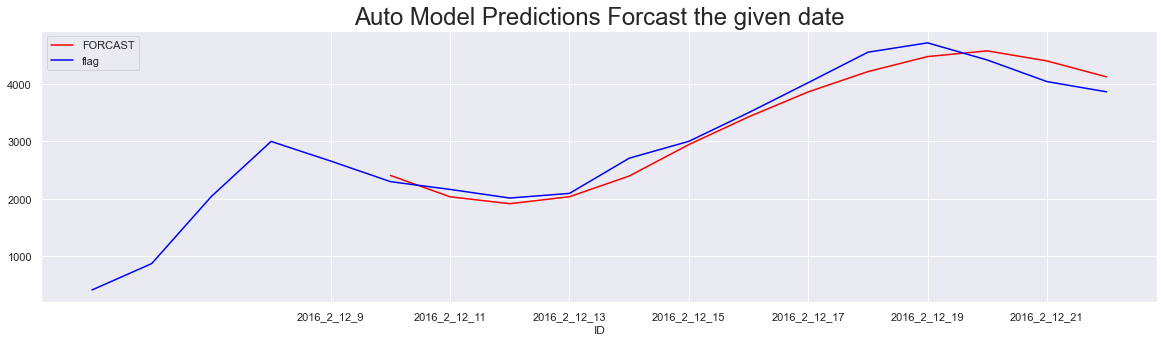

In [24]:
####  Forcast : 2016-feb-12-10 to 2016-feb-12-22:
Start="2016_2_12_5"
Evaluat="2016_2_12_10"
END="2016_2_12_22" 

test_data=df_S[Start:END]
y_data=df_S["flag"][Start:END]

test_generator=TimeseriesGenerator(test_data[selected_features],y_data,length=win_lengh,sampling_rate=1,batch_size=batch_size)
predictions=model.predict_generator(test_generator)

PRED=Tscaler.inverse_transform(predictions)
PRED=[item for sublist in PRED.tolist() for item in sublist]
print(len(PRED),len(y_test))
PRED=[np.nan for x in range(5)]+PRED
print(len(PRED),len(y_test))

report=df_S[Start:END]
report["FORCAST"]=PRED

report.FORCAST.plot(figsize = (20,5), color = "red")
df.flag[Start:END].plot(color = "blue")
plt.title("Auto Model Predictions Forcast the given date", size = 24)
plt.legend()
plt.show()

        

In [25]:
from sklearn.metrics import r2_score
test=df["flag"][Evaluat:END]
Pred=Tscaler.inverse_transform(predictions)
Pred=[item for sublist in Pred.tolist() for item in sublist]

print(len(test),len(Pred))
r2_score(test, Pred)

13 13


0.9531714599658111